**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 

---------------------------------------

This is part of a series of notebooks about practical time series methods:

* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) - **this notebook**
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people)
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences)
* [Part 7: Survival analysis](https://www.kaggle.com/code/konradb/ts-7-survival-analysis)
* [Part 8: Hierarchical time series](https://www.kaggle.com/code/konradb/ts-8-hierarchical-time-series)
* [Part 9: Hybrid methods](https://www.kaggle.com/code/konradb/ts-9-hybrid-methods/)
* [Part 10: Validation methods for time series](https://www.kaggle.com/code/konradb/ts-10-validation-methods-for-time-series/)
* [Part 11: Transfer learning](https://www.kaggle.com/code/konradb/ts-11-deep-learning-for-ts-transfer-learning)


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg) - **based on this notebook**
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E)  
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs)
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk)
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o)
* [Talk 8](https://www.youtube.com/watch?v=7ZTarg4QYR4)
* [Talk 9](https://www.youtube.com/watch?v=NYZzBvKcfp4)
* [Talk 10](https://www.youtube.com/watch?v=47WeBiLV2Uo)
* [Talk 11]()


---------------------------------------


This notebook was inspired by the Q&A part of the YouTube session about ARIMA and friends - the repeated questions about stock performance forecasting suggested it was a topic that reasonated with a lot of people. When we were discussing ARIMA, applying the logic underlying those models was mentioned briefly; one thing leading to another, I decided to add an episode in the series and talk about modeling techniques useful specifically (but not exclusively!) in the financial context.

* [Volatility clustering](#section-one)
* [Mean and variance models](#section-two)
* [Forecasting](#section-three)
* [Value at Risk](#section-four)



In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from scipy.stats import shapiro
from scipy.stats import probplot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
        
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    

In [3]:
!pip install arch

     |████████████████████████████████| 903 kB 261 kB/s            


<a id="section-one"></a>
# Volatility clustering

One of the reason financial time series are challenging to forecast is volatility clustering - periods of high variation in the data cluster together, followed by periods of more stable behavior. You can see an example in the graph below:


<AxesSubplot:xlabel='Date'>

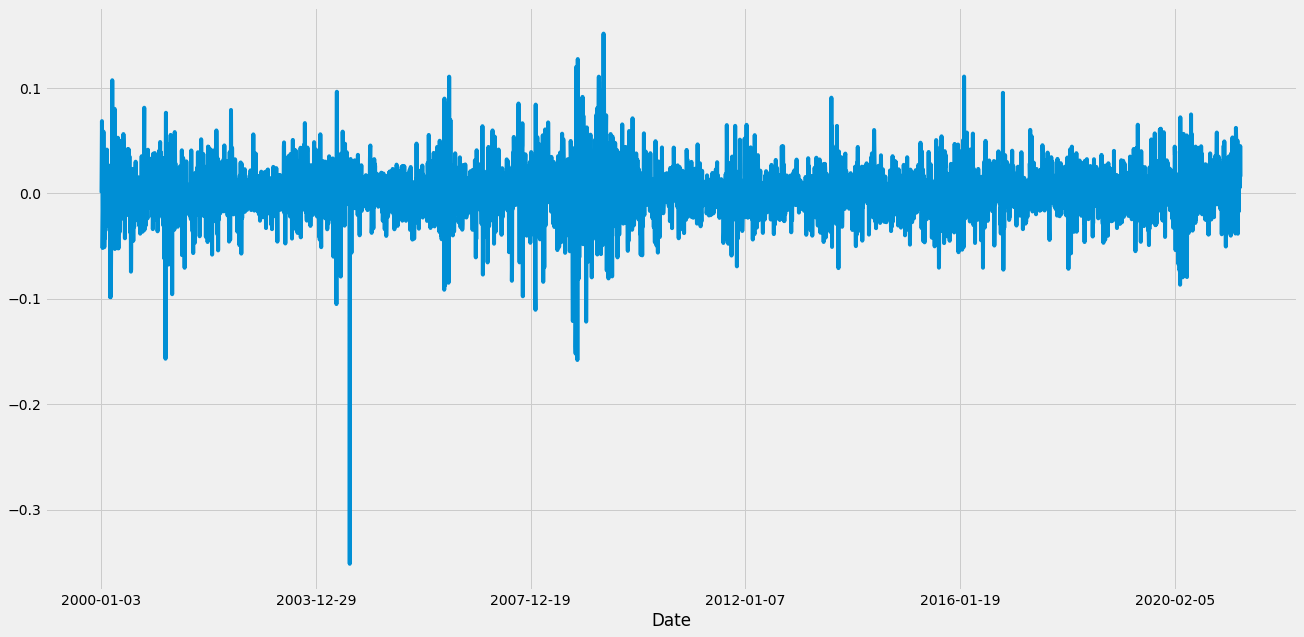

In [4]:
stock_name = 'TATASTEEL'
df = pd.read_csv('../input/nifty50-stock-market-data/'+stock_name+'.csv')
df.set_index("Date", drop=False, inplace=True)

df.VWAP.pct_change().plot()

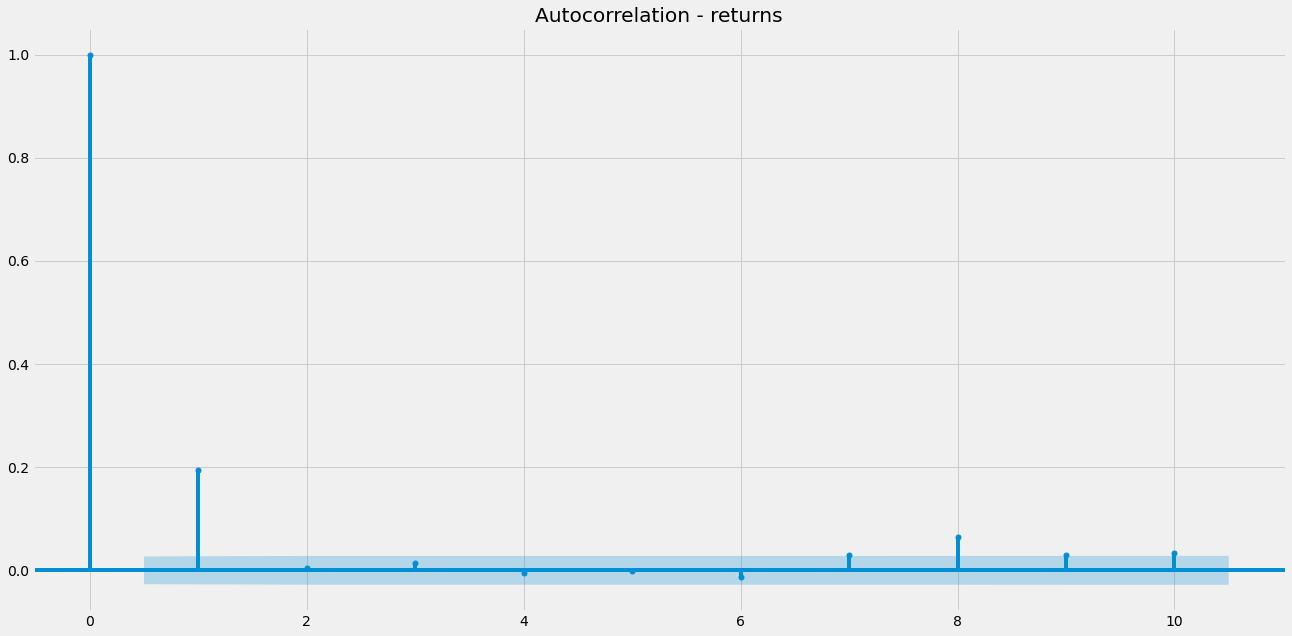

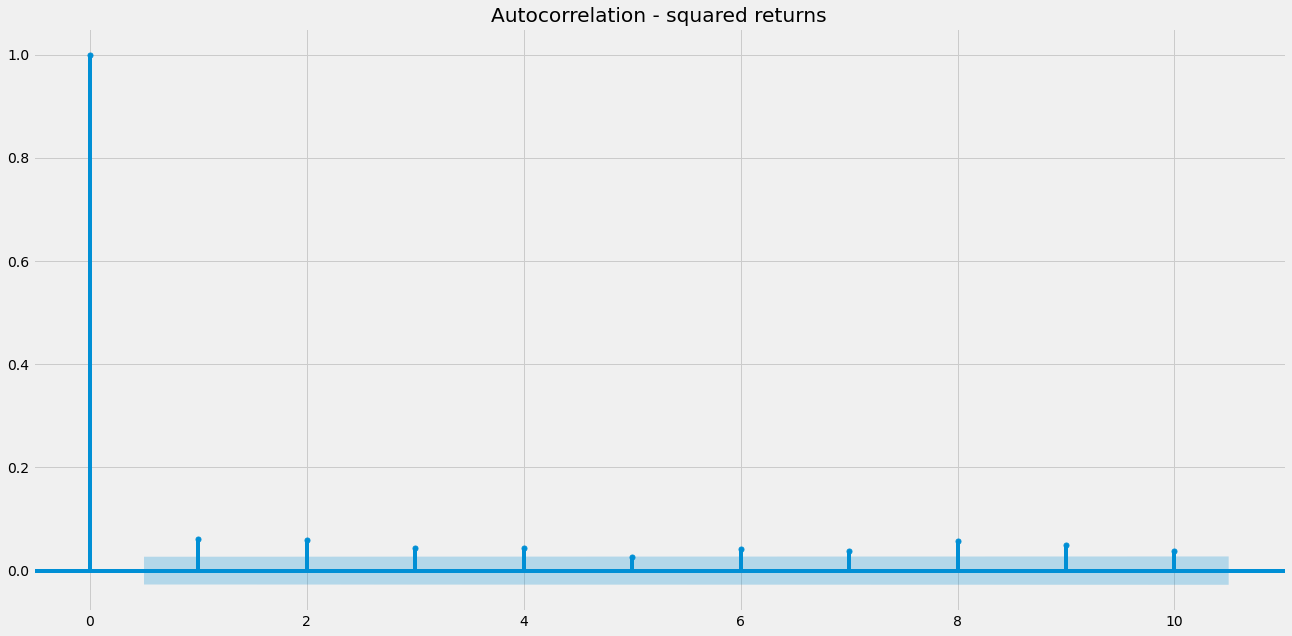

In [5]:
dfl = np.log1p(df.VWAP).diff().dropna()
plot_acf(dfl, lags = 10, title='Autocorrelation - returns'); print()
plot_acf(dfl**2, lags = 10, title='Autocorrelation - squared returns'); print()

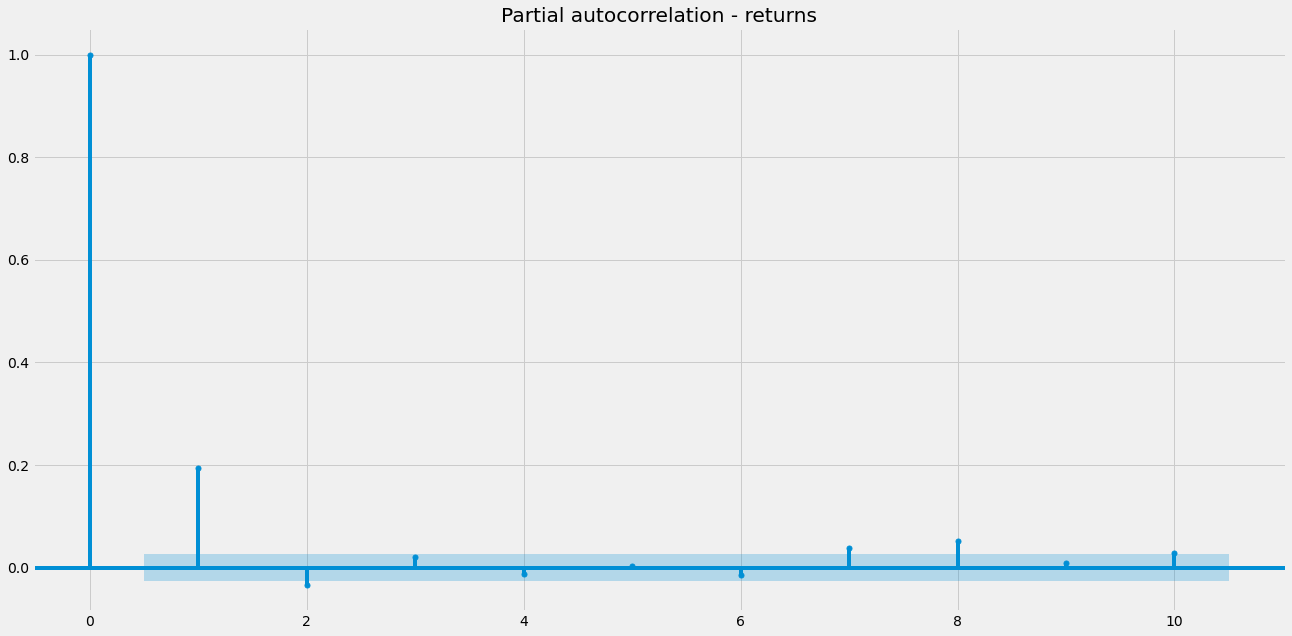

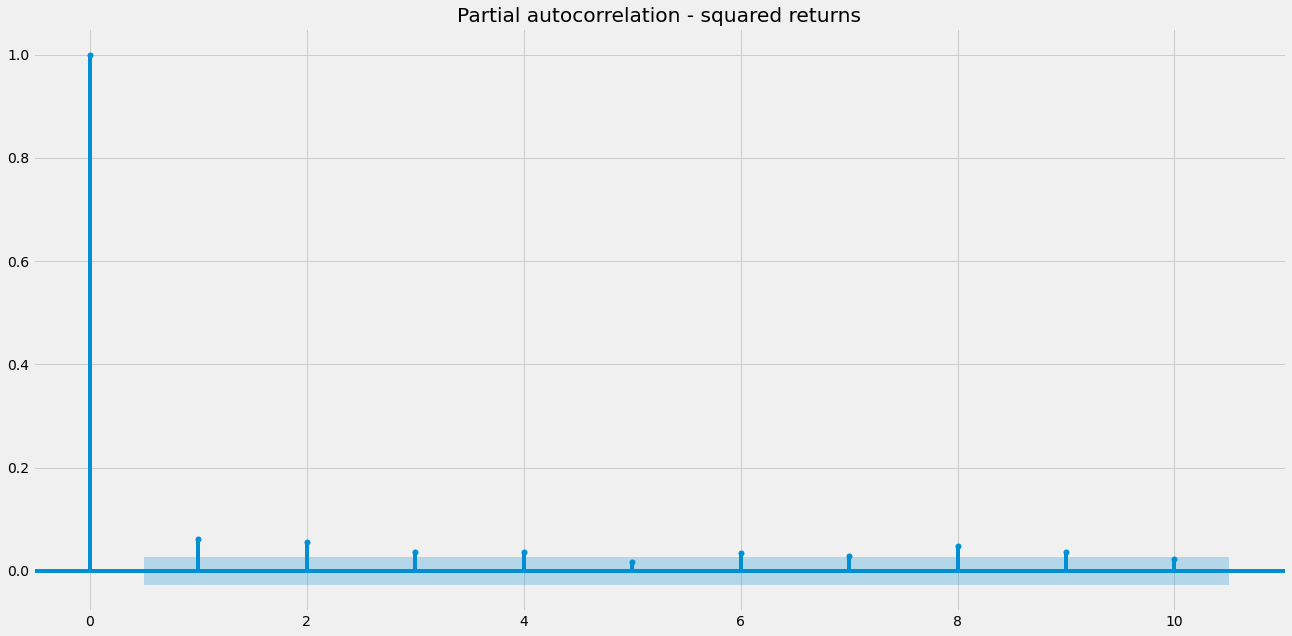

In [6]:

plot_pacf(dfl, lags = 10, title='Partial autocorrelation - returns'); print()
plot_pacf(dfl**2, lags = 10, title='Partial autocorrelation - squared returns'); print()

How do we go about modeling this? 

<a id="section-two"></a>
# Mean and variance models

In the ARIMA episode https://www.kaggle.com/konradb/ts-2-arma-and-friends we have described how a linear model can be specified to predict (conditional) expected value. Similar logic can be applied to build a model for predicting (conditional) variance of the residuals from another model - **and not the value of the series itself**.



## ARCH

A simplest model for time-varying variance is ARCH - the abbreviation stands for **a**uto**r**egressive **c**onditional **h**eteroskedasticity:

\begin{equation}
\sigma_t^2 = \alpha_0 + \sum_{i=1}^p \alpha_i \epsilon_{t-i}^2 \\
\end{equation}

where $\epsilon_t = \sigma_t \; z_t$. Unpacking:

* AR(p) model: the current value (mean / expectation) of the series depends on $p$  previous timesteps values
* ARCH(p): the variance of the current time step is dependent on $p$ lagged squared standard error terms. The standard error is the difference between the observed and predicted value from another model.
* estimated with OLS 
* Lagrange multiplier test

Let's see how we can go about this in practice:

In [7]:
from arch import arch_model

am = arch_model(100 * dfl, p = 1, q = 0)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     32,   Neg. LLF: 12129.135691668853
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12129.1066722275
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -12129.1
Distribution:                  Normal   AIC:                           24264.2
Method:            Maximum Likelihood   BIC:                           24283.9
                                        No. Observations:                 5305
Date:                Fri, Sep 30 2022   Df Residuals:                     5304
Time:                        12:24:04   Df Model:                            1
          

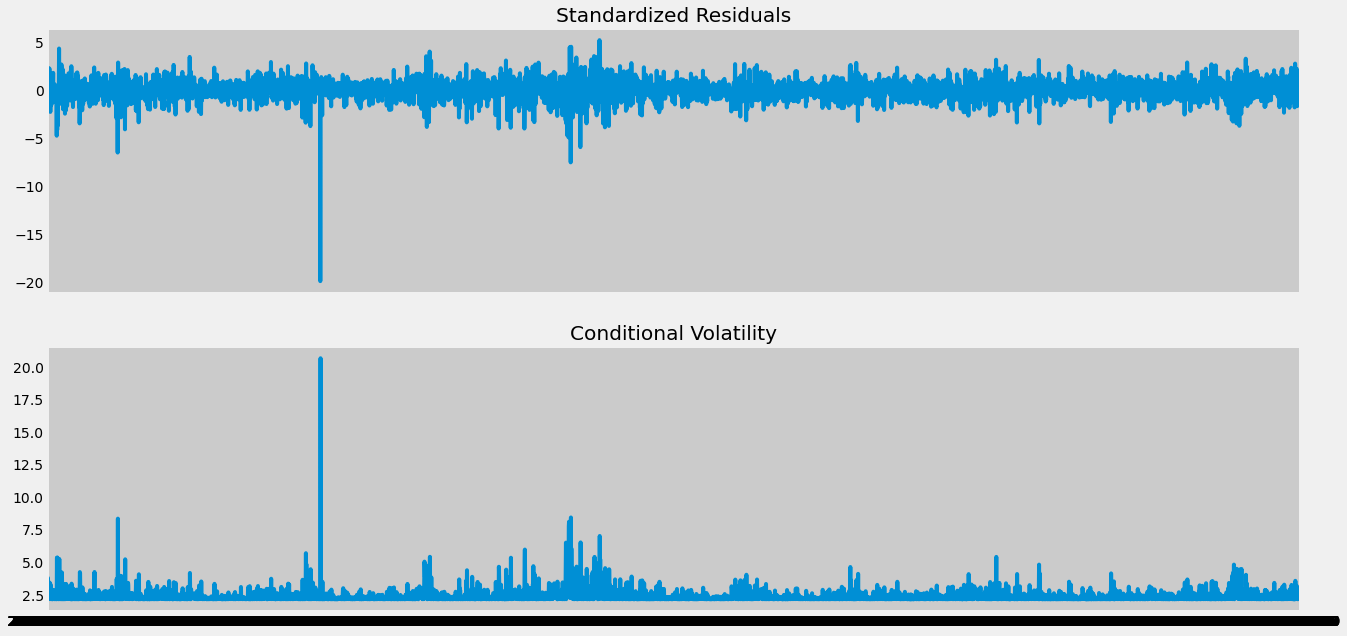

In [8]:
res.plot(); print()

We can run some diagnostics on the model:
* Ljung-Box: 

a test for autocorrelation (usable in tandem with ACF / PACF plots). H0 : The data is independently distributed, no autocorrelation, H1 : there is serial correlation.

* Engle ARCH: Ljung-Box and a Lagrange Multiplier test to determine if our ARCH model has captured the conditional heteroskedasticity 

H0 : the residuals are homoscedastic H1: squared residuals exhibit heteroskedasticity

In [9]:
max_lags = 5
residuals = res.resid
st_residuals = np.divide(res.resid, res.conditional_volatility)

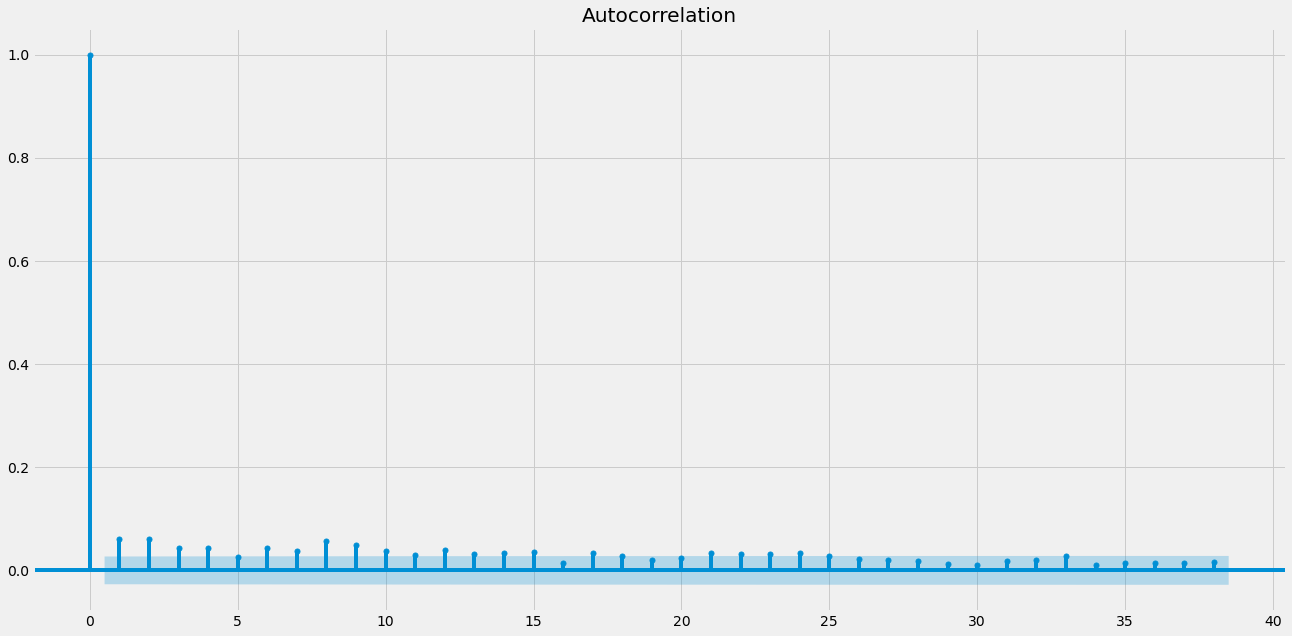

In [10]:
plot_acf(dfl ** 2); print()

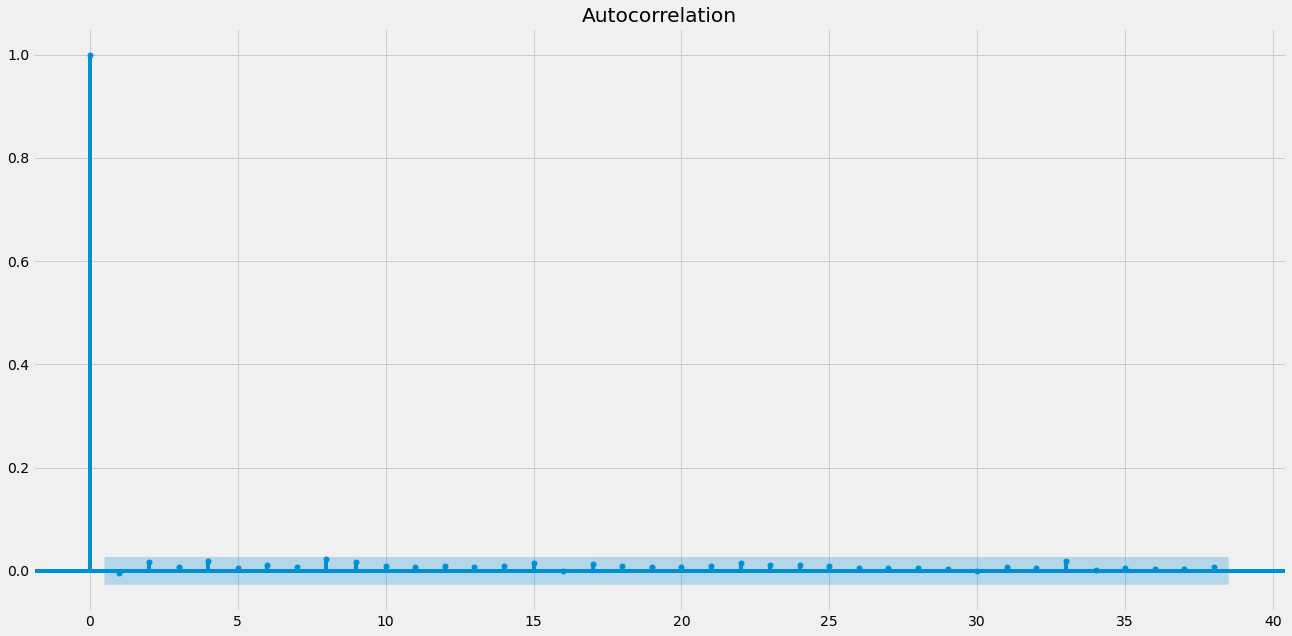

In [11]:
plot_acf(st_residuals ** 2); print()

In [12]:
# Ljung-Box

lb_test = acorr_ljungbox(dfl ** 2 , lags = max_lags)
for lag in range(max_lags):
    print('lag: ' + str(lag) + ' pval: ' + str(np.round( lb_test[1][lag], 4) ))

lag: 0 pval: 0.0
lag: 1 pval: 0.0
lag: 2 pval: 0.0
lag: 3 pval: 0.0
lag: 4 pval: 0.0


In [13]:
lb_test = acorr_ljungbox(st_residuals ** 2 , lags = max_lags)
for lag in range(max_lags):
    print('lag: ' + str(lag) + ' pval: ' + str(np.round( lb_test[1][lag], 4) ))

lag: 0 pval: 0.7807
lag: 1 pval: 0.4318
lag: 2 pval: 0.5617
lag: 3 pval: 0.4001
lag: 4 pval: 0.5123


In [14]:
# Engle ARCH
etest = het_arch(dfl, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.0
pval F-test: 0.0


In [15]:
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.5195
pval F-test: 0.5195


## GARCH

GARCH is an extension of ARCH - it allows for variance depending on its own lags and the lags of the squared residuals. The model formula is:

\begin{equation}
\sigma_t^2 = \omega + \sum_{i=1}^p \alpha_i \epsilon_{t-i}^2 + \sum_{i=1}^q \beta_i \sigma_{t-i}^2\\
\end{equation}
 
Unpacking:
* p - number of lag error terms
* q - number of lag variances
* `arch` notation!


In theory you can specify different orders of $(p,q)$, but absent a good reason to think otherwise it's usually good to start with (1,1).






In [16]:
gm = arch_model(100 * dfl, p = 1, q = 1)
res = gm.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 11838.126029106981
Iteration:     10,   Func. Count:     65,   Neg. LLF: 11835.563882450348
Optimization terminated successfully    (Exit mode 0)
            Current function value: 11835.56177652276
            Iterations: 13
            Function evaluations: 80
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -11835.6
Distribution:                  Normal   AIC:                           23679.1
Method:            Maximum Likelihood   BIC:                           23705.4
                                        No. Observations:                 5305
Date:                Fri, Sep 30 2022   Df Residuals:                     5304
Time:        

In [17]:
# Ljung-Box
residuals = res.resid
st_residuals = np.divide(res.resid, res.conditional_volatility)
lb_test = acorr_ljungbox(dfl ** 2 , lags = max_lags)
for lag in range(max_lags):
    print('lag: ' + str(lag) + ' pval: ' + str(np.round( lb_test[1][lag], 4) ))

lag: 0 pval: 0.0
lag: 1 pval: 0.0
lag: 2 pval: 0.0
lag: 3 pval: 0.0
lag: 4 pval: 0.0


In [18]:
lb_test = acorr_ljungbox(st_residuals ** 2 , lags = max_lags)
for lag in range(max_lags):
    print('lag: ' + str(lag) + ' pval: ' + str(np.round( lb_test[1][lag], 4) ))

lag: 0 pval: 0.6719
lag: 1 pval: 0.8725
lag: 2 pval: 0.9573
lag: 3 pval: 0.9886
lag: 4 pval: 0.9966


In [19]:
# Engle ARCH
etest = het_arch(dfl, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.0
pval F-test: 0.0


In [20]:
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 0.9966
pval F-test: 0.9966


## Extensions

* numerous extensions are possible to the basic GARCH 
* GJR - use asymmetric shock:
\begin{equation}
\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \gamma \mathbf{1}_{\epsilon_{t-1} < 0 } + \beta_1 \sigma_{t-1}^2\\
\end{equation}

* TARCH - absolute values:
\begin{equation}
\sigma_t^k  = \omega + \alpha_1 \left| \epsilon_{t-1} \right|^k + \gamma \left| \epsilon_{t-1} \right|^k   \mathbf{1}_{\epsilon_{t-1} < 0 } + \beta_1 \sigma_{t-1}^k\\
\end{equation}


## ARMA-GARCH

* we assumed constant **mean** so far - frequently not true 
* combine ARIMA and GARCH: conditional mean $\rightarrow$ conditional variance on residuals 
* joint estimation > sequential - estimate consistency

In [21]:
from arch.univariate import ARX

ar = ARX(100 * dfl, lags=[1, 3])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                   VWAP   R-squared:                       0.038
Mean Model:                        AR   Adj. R-squared:                  0.037
Vol Model:          Constant Variance   Log-Likelihood:               -12185.4
Distribution:                  Normal   AIC:                           24378.9
Method:            Maximum Likelihood   BIC:                           24405.2
                                        No. Observations:                 5302
Date:                Fri, Sep 30 2022   Df Residuals:                     5299
Time:                        12:25:40   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const          0.0270  3.328e-02      0.810      0.418 

In [22]:
from arch.univariate import ARCH, GARCH

ar.volatility = GARCH(p=1, q = 1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                   VWAP   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.037
Vol Model:                      GARCH   Log-Likelihood:               -11726.4
Distribution:                  Normal   AIC:                           23464.8
Method:            Maximum Likelihood   BIC:                           23504.2
                                        No. Observations:                 5302
Date:                Fri, Sep 30 2022   Df Residuals:                     5299
Time:                        12:25:41   Df Model:                            3
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const           0.0116  3.169e-02      0.366      0.

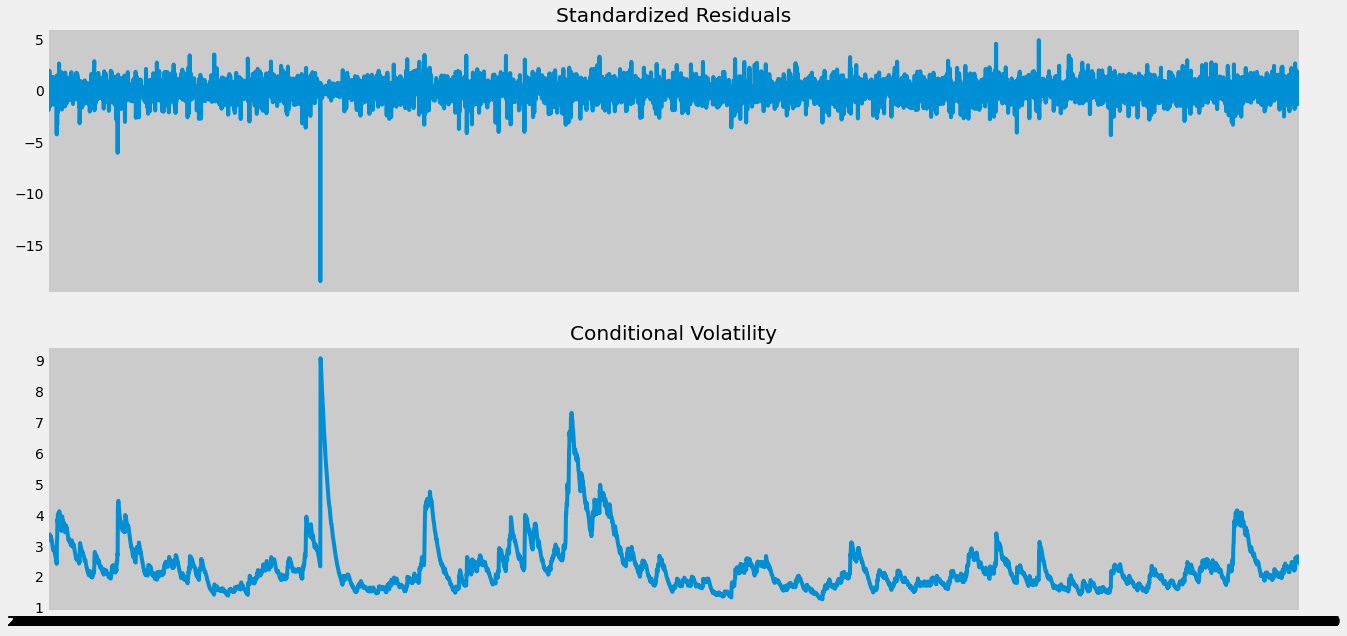

In [23]:
fig = res.plot()

<a id="section-three"></a>
# Forecasting

* multi-step forecasts: recursion $\rightarrow$ analytical form $\sim$ linear in squared residual
* simulation: parametric distribution
* bootstrap: akin to simulation, but empirical residuals


In [24]:

dfl = np.log1p(df.VWAP).diff().dropna()
print(dfl.index.min(), dfl.index.max())

2000-01-04 2021-04-30


In [25]:
# split into training and validation
xtr, xval = dfl.loc[:'2021-01-01'], dfl.loc['2021-01-01':]

In [26]:
# fit the model 

ar = ARX(100 * xtr, lags=[1])
ar.volatility = GARCH(p=1, q = 1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())


                           AR - GARCH Model Results                           
Dep. Variable:                   VWAP   R-squared:                       0.037
Mean Model:                        AR   Adj. R-squared:                  0.037
Vol Model:                      GARCH   Log-Likelihood:               -11547.9
Distribution:                  Normal   AIC:                           23105.7
Method:            Maximum Likelihood   BIC:                           23138.5
                                        No. Observations:                 5225
Date:                Fri, Sep 30 2022   Df Residuals:                     5223
Time:                        12:27:15   Df Model:                            2
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
Const      7.6358e-03  3.177e-02      0.240      0.810 

In [27]:
# build the forecast
xfor = res.forecast(horizon= xval.shape[0])

# ugly workaround, I know
mean_forecast = xfor.mean.tail(1).values.reshape(len(xval),1)

forecast = pd.DataFrame()
forecast['Date'] = xval.index
forecast['VWAP'] = xval.values
forecast['fc_mean'] = xfor.mean.tail(1).values.reshape(len(xval),1)
forecast['fc_std'] = np.sqrt(xfor.variance.tail(1).values.reshape(len(xval),1))

In [28]:
forecast

,Date,VWAP,fc_mean,fc_std
0,2021-01-01,-0.000635,-0.005309,1.956875
1,2021-01-04,0.044198,0.006553,2.001682
2,2021-01-05,0.013379,0.008972,2.008021
3,2021-01-06,0.003357,0.009466,2.012758
4,2021-01-07,0.048117,0.009566,2.017403
...,...,...,...,...
75,2021-04-26,0.013062,0.009592,2.293164
76,2021-04-27,0.023504,0.009592,2.296414
77,2021-04-28,0.006857,0.009592,2.299650
78,2021-04-29,0.043910,0.009592,2.302871


<a id="section-four"></a>
# Value at Risk


In [29]:
from IPython.display import Image
Image(url="http://upload.wikimedia.org/wikipedia/commons/6/64/VaR_diagram.JPG")


* VaR is a measure of the risk of loss for investments
* imperfect, but very popular
* estimates how much a set of investments might lose (with a given probability), given normal market conditions, in a set time period such as a day
* GARCH: VaR $\sim$ conditional mean, the conditional volatility and the quantile of the standardized residuals

\begin{equation}
VaR_{t+1|t} = -\mu_{t+1|t} - \sigma_{t+1|t} q_q
\end{equation}


In [30]:
import arch.data.sp500

data = arch.data.sp500.load()
market = data["Adj Close"]
returns = 100 * market.pct_change().dropna()

In [31]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="skewt")
res = am.fit(disp="off", last_obs="2017-12-31")

In [32]:
forecasts = res.forecast(start="2018-1-1", reindex=False)
cond_mean = forecasts.mean["2018":]
cond_var = forecasts.variance["2018":]
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.64484999 -1.64965918]


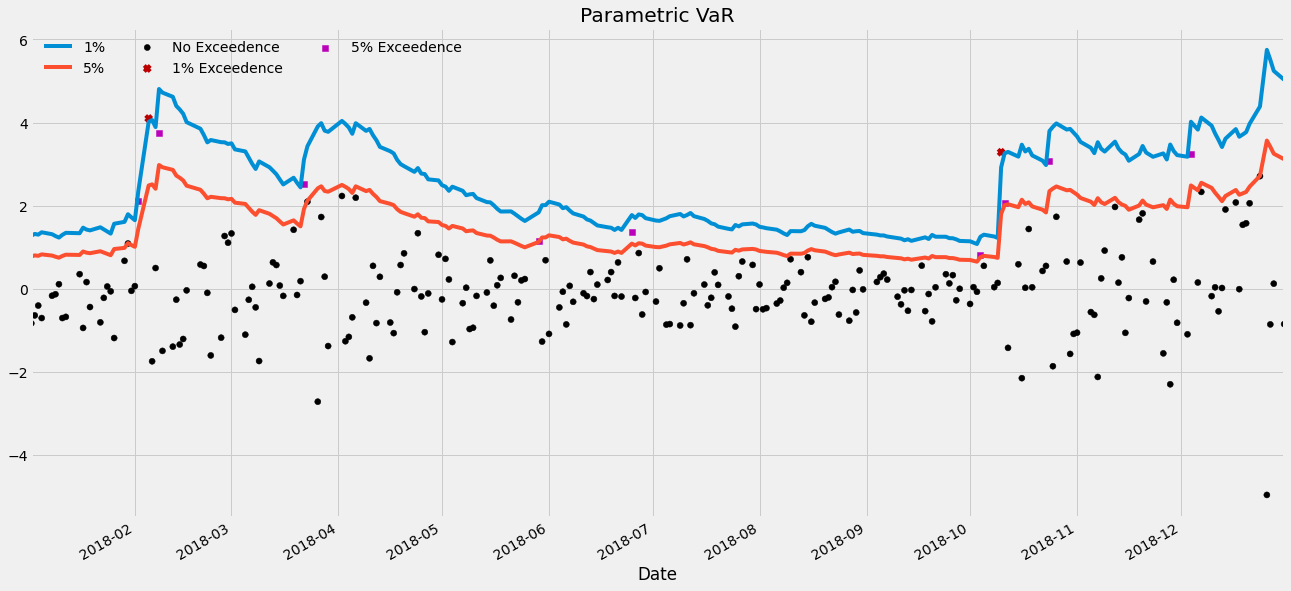

In [33]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns["2018":].copy()
rets_2018.name = "S&P 500 Return"
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < -value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {"#BB0000": "1% Exceedence", "#BB00BB": "5% Exceedence", "#000000": "No Exceedence",}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)